### 2nd European Conference on Social Networks, June 14-17, 2016, Paris (http://eusn2016.sciencesconf.org/)
## Workshop 12:
# EXTRACTING SOCIAL NETWORKS FROM LITERARY TEXT
# II. Using Names of Characters from Inside the Text
## By Moses Boudourides (<mailto:Moses.Boudourides@gmail.com>) and Sergios Lenis (<mailto:sergioslenis@gmail.com>) 
## University of Patras, Greece

**IMPORTANT**: To use this notebook, you'll need to

1. Install IPython Notebook (easiest way: use [Anaconda](http://store.continuum.io))
2. Download this notebook and all other Python scripts used here from [https://github.com/mboudour/WordNets/blob/master/EUSN2016_LiteraryTextNetworksWorkshop](https://github.com/mboudour/WordNets/blob/master/EUSN2016_LiteraryTextNetworksWorkshop)
3. Run `ipython notebook` in the same directory where notebook and scripts were put

<a href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

<p>
**Table of Contents**

[I. Importing the Text & Names of Characters](#I)

[II. Descriptive Statistics of Characters](#II)

[III. The Two-Mode Network of Characters and Sentences](#III)

[IV. The Network of Sententially Co-Occurring Characters](#IV)

[V. Trajectories of Transitions among Sentential Co-Occurrences of Characters](#V)

## Importing Python modules 

In [1]:
import random
import nltk
import codecs
# from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os
import imp
import seaborn as sns       # pip install seaborn
sns.set_style("white")      # For seaborn to show axes in iPython Notebook
from lightning import Lightning
from numpy import random, asarray, sqrt, arctan2, pi, clip
from seaborn import color_palette
from sklearn import datasets
from colorsys import hsv_to_rgb

# utilsdir='/Users/mosesboudourides/Dropbox/Python Projects/EUSN2016_LiteraryTextNetworksWorkshop/utils/'
# utilsdir='/home/mab/Dropbox/Python Projects/utils/'#tools.py'
utilsdir='/home/mab/Dropbox/Python Projects/EUSN2016_LiteraryTextNetworksWorkshop/utils/'
# utilsdir='/home/sergios-len/Dropbox/Python Projects (1)/EUSN2016_LiteraryTextNetworksWorkshop/utils/'

%matplotlib inline 
%load_ext autoreload

/home/mab/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# The case of William Shakespeare's "King Lear"

<a id='I'></a>
## I. Importing the Text & Names of Characters

In [2]:
# The transcript of William Shakespeare's Hamlet was downloaded from 
# http://shakespeare.mit.edu/hamlet/full.html (accessed on 4-18-2016)

filename = 'texts/KingLear.txt'
titlename = "William Shakespeare's King Lear"
central_hero = 'King Lear'
nn1 = "William Shakespeare's King Lear selected terms"
nn2 = "William Shakespeare's King Lear Characters"
vname1 = 'vids/KingLear.gif'
vname2 = 'vids/KingLear.mp4'
nn3 = "['King Lear']"
filename1 = 'S_out_graphs/King lear_graph.graphml'

f=open(filename)

num_lines = 0
num_words = 0
num_chars = 0
names=set()
for line in f:    
    words = line.split()
    num_lines += 1
    num_words += len(words)
    num_chars += len(line)
    lin=line.strip()
    if len(lin)>0:
        if lin[0]=='*' and lin[-1]=='*':
            lin=lin[1:-1]
            if '*' in lin:                
                nlin=lin.split()
                for nl in nlin:
                    nl=nl.strip('*')
                    names.add(nl.strip(':'))
            else:
                names.add(lin)
print "%s has number of words = %i and number of characters = %i" %(titlename,num_words,num_chars)

f = codecs.open(filename, "r", encoding="utf-8").read()

William Shakespeare's King Lear has number of words = 27582 and number of characters = 174493


In [3]:
# "names" are defined as the the words in lines of the text including a single word.

list(names)

['Gentleman',
 'Doctor',
 'Old Man',
 'Second Servant',
 'CORNWALL',
 'Messenger',
 'Fool',
 'ALBANY',
 'ALBANY CORNWALL',
 'CORDELIA',
 'EDMUND',
 'KING LEAR',
 'Third Servant',
 'EDGAR',
 'Herald',
 'GONERIL',
 'OSWALD',
 'REGAN',
 'First Servant',
 'LEAR',
 'KENT',
 'Captain',
 'GLOUCESTER']

In [4]:
dici={'Gentleman':'Gentleman',
 'Doctor':'Doctor',
 'Old Man':'Old Man',
 'Second Servant':'Servant',
 'CORNWALL':'CORNWALL',
 'Messenger':'Messenger',
 'Fool':'Fool',
 'ALBANY':'ALBANY',
 'ALBANY CORNWALL':'CORNWALL',
 'CORDELIA':'CORDELIA',
 'EDMUND':'EDMUND',
 'KING LEAR':'KING LEAR',
 'Third Servant':'Servant',
 'EDGAR':'EDGAR',
 'Herald':'Herald',
 'GONERIL':'GONERIL',
 'OSWALD':'OSWALD',
 'REGAN':'REGAN',
 'First Servant':'Servant',
 'LEAR':'KING LEAR',
 'KENT':'KENT',
 'Captain':'Captain',
 'GLOUCESTER':'GLOUCESTER'}

ndici={i.lower():k.lower().capitalize() for i,k in dici.items()}
dnici=[(i.split()[0],i.split()[1]) for i in ndici.keys() if len(i.split())>1]

ndici['lear']='King Lear'
ndici['king lear']='King Lear'

selectedTerms=ndici.keys()
new_text={l:{} for l in selectedTerms}
f=open(filename)
chars=[]
texx=''
u=0
for lin in f:
    lin=lin.strip()
    if '*' in lin:
        if len(chars)>0 and len(texx)>0:
            for cr in chars:
                new_text[cr[0]][cr[1]]=texx
        chars=[]
        line= lin.split('*')
        
        for ll in line:
            if ll.lower() in selectedTerms:
                chars.append((ll.lower(),u))
        texx=''
    elif len(lin)>0 and lin[0] =='/':
        continue
    else:
        if len(chars)>0:
            texx+=lin
    u+=1     

In [5]:
%autoreload 2

tool= imp.load_source('tools', utilsdir+'tools.py')
# print dir(tool)

create_pandas_dataframe_from_text_par=tool.create_pandas_dataframe_from_text_par
create_coo_graph=tool.create_coo_graph

dfst,sec_prot,coccurlist,occurlist,dflines=create_pandas_dataframe_from_text_par(new_text,selectedTerms,ndici,titlename)
co_graph=create_coo_graph(coccurlist)

dfst.rename(columns={nn1:nn2},inplace=True)
# dfst.rename(columns={"Arthur Conan Doyle's A Study in Scarlet selected terms":"Arthur Conan Doyle's A Study in Scarlet Characters"},inplace=True)
dfst.sort_values(by='Frequencies').sort(["Frequencies"], ascending=[0])

/home/mab/.local/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


William Shakespeare's King Lear Characters  Frequencies
2                                   King Lear        203.0
13                                       Kent        151.0
18                                 Gloucester        148.0
12                                     Edmund        109.0
8                                       Edgar        108.0
15                                      Regan         87.0
17                                   Cornwall         67.0
10                                    Goneril         65.0
1                                      Albany         65.0
0                                        Fool         59.0
7                                    Cordelia         48.0
14                                     Oswald         43.0
5                                   Gentleman         37.0
6                                     Old man         17.0
4                                     Servant          8.0
3                                      Doctor          8.0
11                                  Messenger          7.0
16                                    Captain          5.0
9                                      Herald          4.0

In [6]:
prot_pol_sub=dflines[['narrator','protagonists','#_of_protagonists','polarity','subjectivity']].reset_index()
prot_pol_sub['sentence_id']=prot_pol_sub.index
prot_pol_sub=prot_pol_sub[['sentence_id','narrator','protagonists','#_of_protagonists','polarity','subjectivity']]

cuts = 0
# prot_pol_sub = prot_pol_sub[prot_pol_sub['#_of_protagonists']>cuts]
lp = prot_pol_sub['protagonists'].tolist()
lpn = []
for i in lp:
    for j in i:
        lpn.append(j)
# len(set(lpn))
print "The total number of sentences in %s is %i." %(titlename,len(prot_pol_sub))
# print "The total number of sentences in %s with at least %i characters in each one of them is %i." %(titlename,cuts+1,len(prot_pol_sub))
prot_pol_sub.rename(columns={'protagonists':'Lists_of_Characters','#_of_protagonists':'#_of_Characters','polarity':'Polarity','subjectivity':'Subjectivity'},inplace=True)
prot_pol_sub.sort(["#_of_Characters"], ascending=[0]) 
ddff = prot_pol_sub.drop('sentence_id', 1)
ddff.index.name = 'Sentence_ID'
ddff.head(10)

The total number of sentences in William Shakespeare's King Lear is 1046.


/home/mab/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


narrator Lists_of_Characters  #_of_Characters  Polarity  \
Sentence_ID                                                           
0            Old man                  []              0.0    0.0000   
1            Old man                  []              0.0    0.7000   
2            Old man                  []              0.0   -0.5125   
3            Old man                  []              0.0    1.0000   
4            Old man                  []              0.0   -0.6250   
5            Old man                  []              0.0    0.0000   
6            Old man                  []              0.0    0.0000   
7            Old man                  []              0.0    0.0000   
8            Old man                  []              0.0    0.0000   
9            Servant                  []              0.0    0.1000   

             Subjectivity  
Sentence_ID                
0                     0.0  
1                     0.6  
2                     0.8  
3                     0.3  
4                     1.0  
5                     0.0  
6                     0.0  
7                     0.0  
8                     0.0  
9                     0.2

<a id='II'></a>
## II. Descriptive Statistics of Characters

In [7]:
prot_pol_sub[['#_of_Characters','Polarity','Subjectivity']].describe()

#_of_Characters     Polarity  Subjectivity
count      1046.000000  1046.000000   1046.000000
mean          0.184512     0.070084      0.299342
std           0.502043     0.279141      0.319609
min           0.000000    -1.000000      0.000000
25%           0.000000     0.000000      0.000000
50%           0.000000     0.000000      0.220833
75%           0.000000     0.165104      0.562269
max           5.000000     1.000000      1.000000

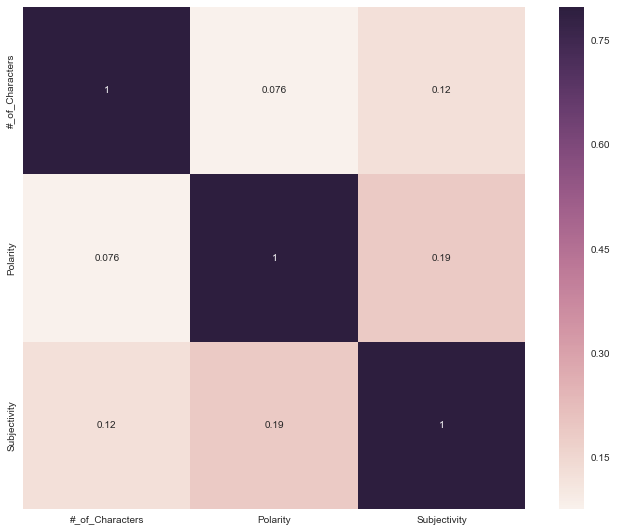

In [8]:
ddff = prot_pol_sub.drop('sentence_id', 1)
corrmat = ddff.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

/home/mab/.local/lib/python2.7/site-packages/pandas/tools/plotting.py:3369: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "the passed axes is being cleared", UserWarning)


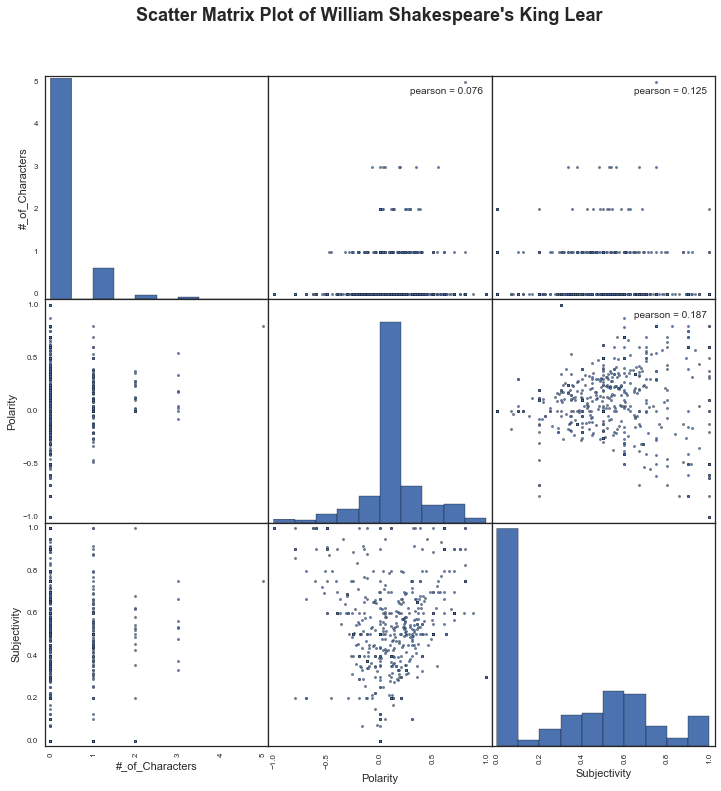

In [9]:
from pandas.tools.plotting import scatter_matrix

ntei='Scatter Matrix Plot of ' + titlename
f, ax = plt.subplots(figsize=(12,12))
# nddd
sss=scatter_matrix(ddff[['#_of_Characters','Polarity','Subjectivity']], alpha=0.9, color='black', diagonal='hist',ax=ax)
plt.suptitle(ntei,fontsize=18,fontweight='bold')
corr = ddff.corr().as_matrix() #nddd.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sss, k=1)):
    sss[i, j].annotate("pearson = %.3f" %corr[i,j], (0.8, 0.93), xycoords='axes fraction', ha='center', va='center')

### The Histogram of the Number of Characters 

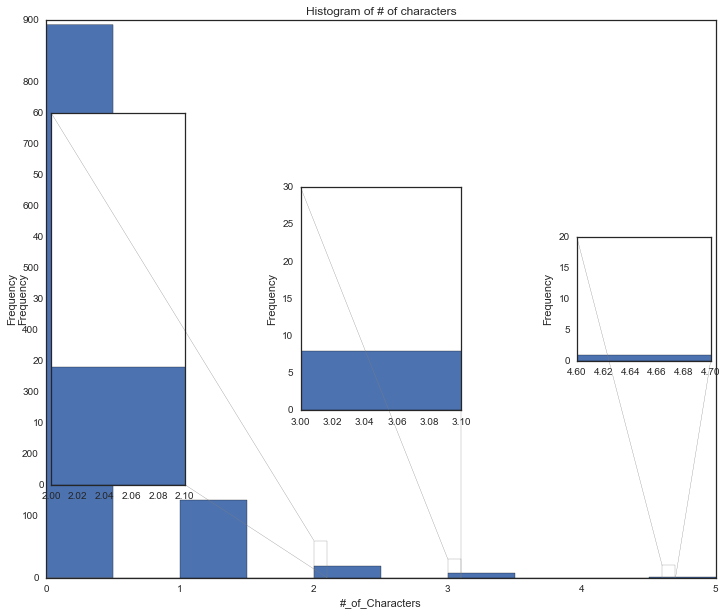

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

ndfl=dflines[dflines['#_of_protagonists']>0  ]

fig, ax = plt.subplots(figsize=[12, 10])
axes2 = zoomed_inset_axes(ax, 12, loc=10)  # zoom = 6  

dflines['#_of_protagonists'].plot.hist(ax=ax)

ax.set_xlabel('#_of_Characters')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of # of characters')

x1, x2, y1, y2 = 3, 3.1, 0, 30
axes2.set_xlim(x1, x2)
axes2.set_ylim(y1, y2)
ndfl['#_of_protagonists'].plot.hist(ax=axes2)
axes2.set_ylabel('Frequency')

mark_inset(ax, axes2, loc1=2, loc2=4, fc="none", ec="0.5")
axes3 = zoomed_inset_axes(ax, 10, loc=6)

x1, x2, y1, y2 = 2, 2.1, 0, 60
axes3.set_xlim(x1, x2)
axes3.set_ylim(y1, y2)
ndfl['#_of_protagonists'].plot.hist(ax=axes3)
axes3.set_ylabel('Frequency')

mark_inset(ax, axes3, loc1=2, loc2=4, fc="none", ec="0.5")

axes4 = zoomed_inset_axes(ax, 10, loc=7)

x1, x2, y1, y2 = 4.6, 4.7, 0, 20
# x1, x2, y1, y2 = 3.9, 4, 0, 20
axes4.set_xlim(x1, x2)
axes4.set_ylim(y1, y2)
ndfl['#_of_protagonists'].plot.hist(ax=axes4)
axes3.set_ylabel('Frequency')

mark_inset(ax, axes4, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

### Various Scatter Plots

In [11]:
x = ddff['Polarity']
y = ddff['Subjectivity']
z = ddff['#_of_Characters']


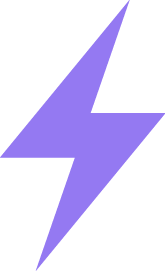

Connected to server at http://public.lightning-viz.org


<IPython.core.display.Javascript object>

In [12]:
lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')

In [13]:
series = [x,y]
lgn.line(series)

/home/mab/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [14]:
viz = lgn.scatter(x, y, values = z, alpha=0.6, colormap='YlOrRd')
viz

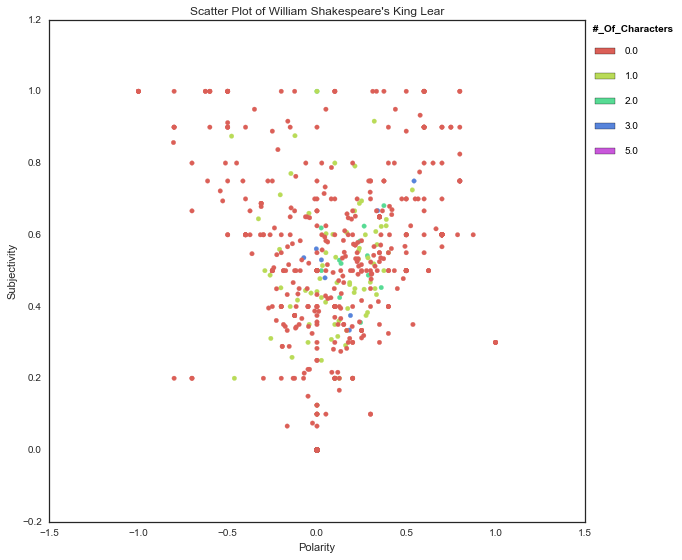

<ggplot: (8788788404249)>

In [15]:
from ggplot import *
import matplotlib as mpl

ntei='Scatter Plot of ' + titlename

p = ggplot(aes(x='Polarity', y='Subjectivity',color='#_of_Characters'), data=ddff) #nddd)
p + geom_point() + ggtitle(ntei) + theme_matplotlib(rc={"figure.figsize": "12, 9"}, matplotlib_defaults=False)

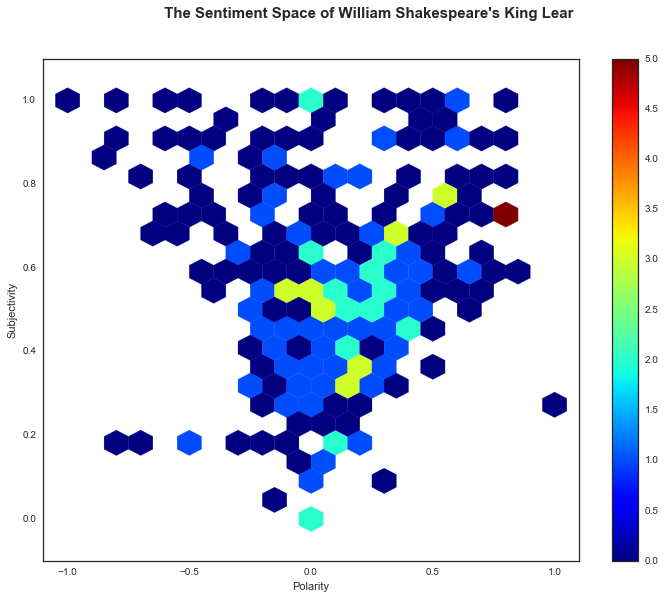

In [16]:
ntei=' The Sentiment Space of ' + titlename
f, ax = plt.subplots(figsize=(12,9))
ddff.plot.hexbin(x='Polarity',y='Subjectivity',gridsize=20,C='#_of_Characters',ax=ax,reduce_C_function=max,cmap='jet')#,title=ntei)
plt.xlim(-1.1, 1.1)
plt.ylim(-.1, 1.1)
plt.suptitle(ntei,fontsize=15,fontweight='bold')

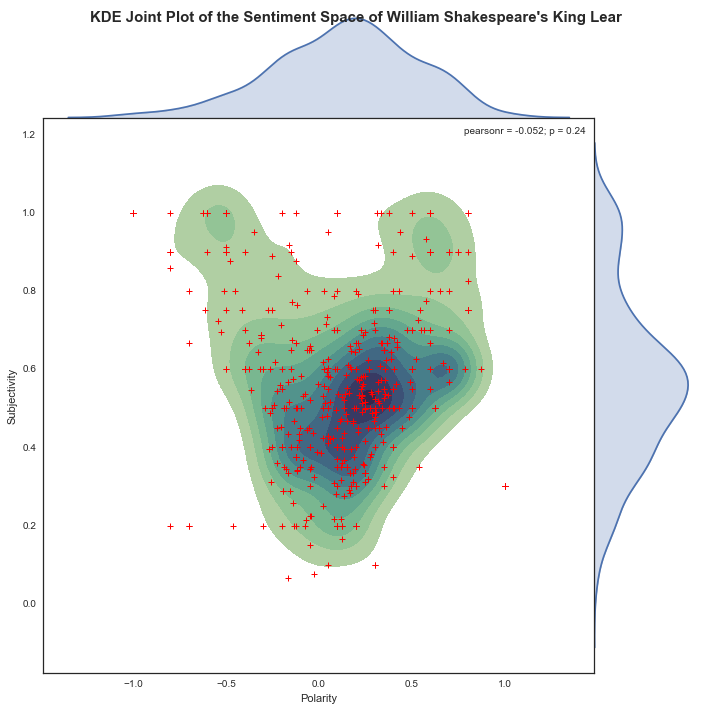

In [17]:
nddd=ddff[ddff['Polarity'] !=0 ]#& ddff['Subjectivity'] !=0]
nddd=nddd[nddd['Subjectivity'] !=0]

ntei='KDE Joint Plot of the Sentiment Space of ' + titlename
# f, ax = plt.subplots(figsize=(10,10))
# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
ggn=sns.jointplot(x='Polarity',y='Subjectivity', data=nddd, kind ="kde",cmap=cmap,space=0, size=10) #, ax=ax) #kind="kde",
# sns.kdeplot(nddd['Polarity'],nddd['Subjectivity'], cmap=cmap, shade=True)
ggn.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
ggn.ax_joint.collections[0].set_alpha(0)
ggn.set_axis_labels("Polarity", "Subjectivity")
plt.suptitle(ntei,fontsize=15,fontweight='bold')

In [18]:
# pols=nddd.Polarity.tolist()
# subj=nddd.Subjectivity.tolist()
# ntei=titlename+' in Sentiment Space'
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# fig, ax = plt.subplots()
# plt.xlim(-1.1, 1.1)
# plt.ylim(-.1, 1.1)
# ax.set_xlabel('Polarity')
# ax.set_ylabel('Subjectivity')   

# # arro=ax.arrow(pols[0], subj[0], pols[1]-pols[0], subj[1]-subj[0], head_width=0.03, head_length=0, fc='b', ec='b',
# #                   length_includes_head=False,
# # # #                  head_starts_at_zero=True
# # # #                  overhang=-.51
# #                  fill=False)

# def animate(i):
#     col=(1.*i/(1.*len(pols)),.5,.5)
#     plt.plot(pols[i],subj[i],'o',color=col, markersize=5)
# #     return arro,

# ani = animation.FuncAnimation(fig, animate, np.arange(0, len(pols)-1), 
#     interval=25, blit=False)

# # ani.save(vname2)#, metadata={'artist':'Guido'})
# ani.save(vname1, writer='imagemagick')
# plt.show()
# print len(pols)

In [19]:
# %%bash
# ffmpeg -f gif -i vids/KingLear.gif vids/KingLear.mp4

In [20]:
import io
import base64
from IPython.display import HTML

video = io.open(vname2, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# /Users/mosesboudourides/Dropbox/Python Projects/LiteratureNetworks/ArthurConanDoyle/SherlockHolmesStoriesNetwork/

<a id='III'></a>
## III. The Two-Mode Network of Characters and Sentences 

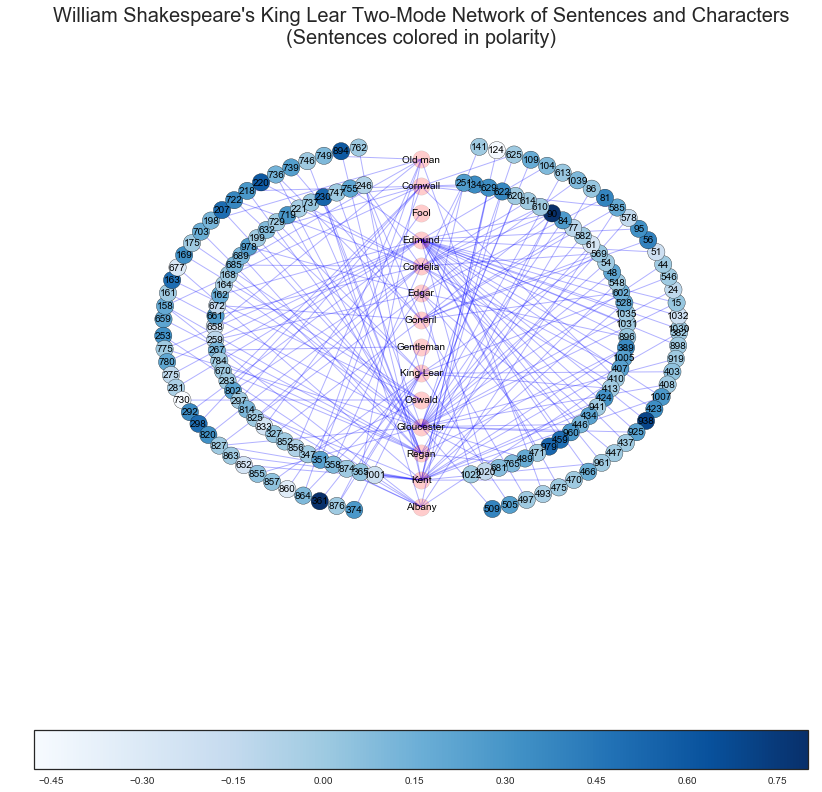

In [21]:
%autoreload 2
import math

draw_network_node_color=tool.draw_network_node_color

sstt="%s Two-Mode Network of Sentences and Characters" %titlename
pos=nx.spring_layout(sec_prot)
nds=[nd for nd in sec_prot.nodes() if isinstance(nd,int)]
prot=[nd for nd in sec_prot.nodes() if nd not in nds]
qua=len(nds)/4.
for en,nd in enumerate(nds):  
    if en<qua:
        if en%2==0:
            rr=1.
        else:
            rr=.8
        the=math.pi*en/(190*72./len(nds))
        pos[nd][0]=rr*math.cos(the)
        pos[nd][1]=rr*math.sin(the)
    elif en<len(nds)/2. and en>qua:
        ens=en-qua
        the=math.pi*ens/(190*72./len(nds))
        if en%2==0:
            rr=1.
        else:
            rr=.8
        pos[nd][0]=-rr*math.cos(the)
        pos[nd][1]=rr*math.sin(the)
    elif en<3*qua and en>2*qua:
        ens=en-2*qua
        the=math.pi*ens/(190*72./len(nds))
        if en%2==0:
            rr=1.
        else:
            rr=.8
        pos[nd][0]=-rr*math.cos(the)
        pos[nd][1]=-rr*math.sin(the)
    else:
        ens=en-3*qua
        the=math.pi*ens/(190*72./len(nds))
        if en%2==0:
            rr=1.
        else:
            rr=.8
        pos[nd][0]=rr*math.cos(the)
        pos[nd][1]=-rr*math.sin(the)
for en ,nd in enumerate(prot):
    pos[nd][0]=0
    pos[nd][1]=-0.95+en*2./len(prot)

possit=draw_network_node_color(sec_prot,sstt,pos=pos,with_edgewidth=False,withLabels=True,labfs=10,valpha=0.2,
                               ealpha=0.3,labelfont=5,with_node_weight=False,node_size_fixer=10.,node_col='polarity',
                              node_size_def=None)

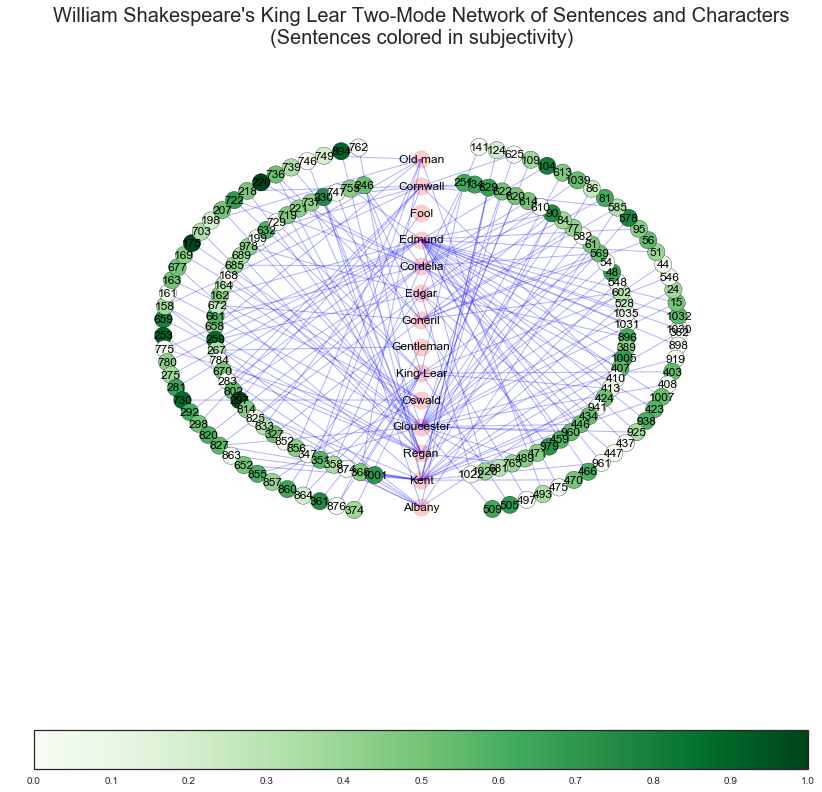

In [22]:
possit=draw_network_node_color(sec_prot,sstt,pos=pos,with_edgewidth=False,withLabels=True,labfs=12,valpha=0.2,
                               ealpha=0.3,labelfont=15,with_node_weight=False,node_size_fixer=300.,
                               node_col='subjectivity',colormat='Greens')

<a id='IV'></a>
## IV. The Network of Sententially Co-Occurring Characters 

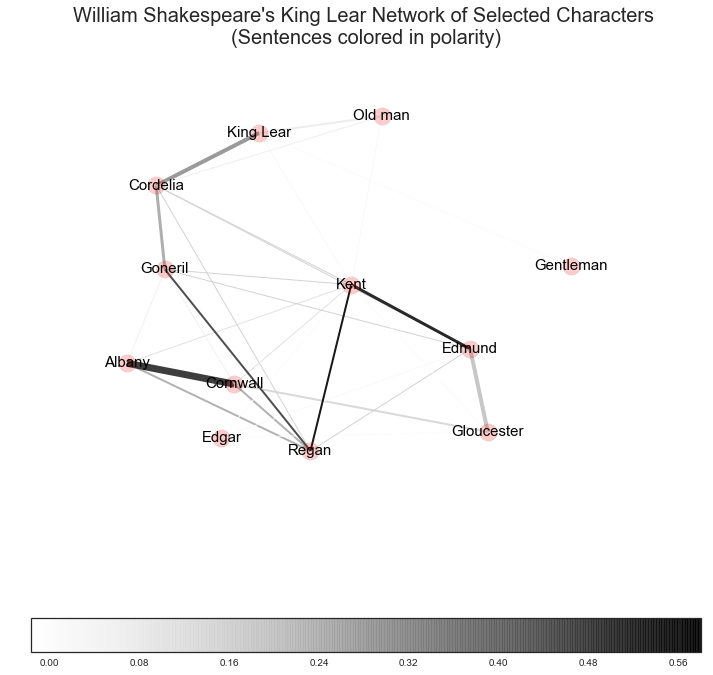

In [23]:
%autoreload 2

draw_network=tool.draw_network
make_graph_from_lists=tool.make_graph_from_lists


plist = prot_pol_sub['Lists_of_Characters'].tolist()
pplist=prot_pol_sub['Polarity'].tolist()
nplist=prot_pol_sub['#_of_Characters'].tolist()
splist=prot_pol_sub['Subjectivity'].tolist()

G = make_graph_from_lists(plist,pplist,nplist,splist)
posg=nx.spring_layout(G,scale=50,k=0.55,iterations=20)
# posg=nx.spring_layout(G,scale=50)#,k=0.55)#,iterations=20)

sstt="%s Network of Selected Characters \n(Sentences colored in polarity)" %titlename
possit=draw_network(G,sstt,pos=posg,with_edgewidth=True,withLabels=True,labfs=15,valpha=0.2,ealpha=0.9,labelfont=15,
                   with_edgecolor=True,edgecolor='polarity',colormat='Blues')

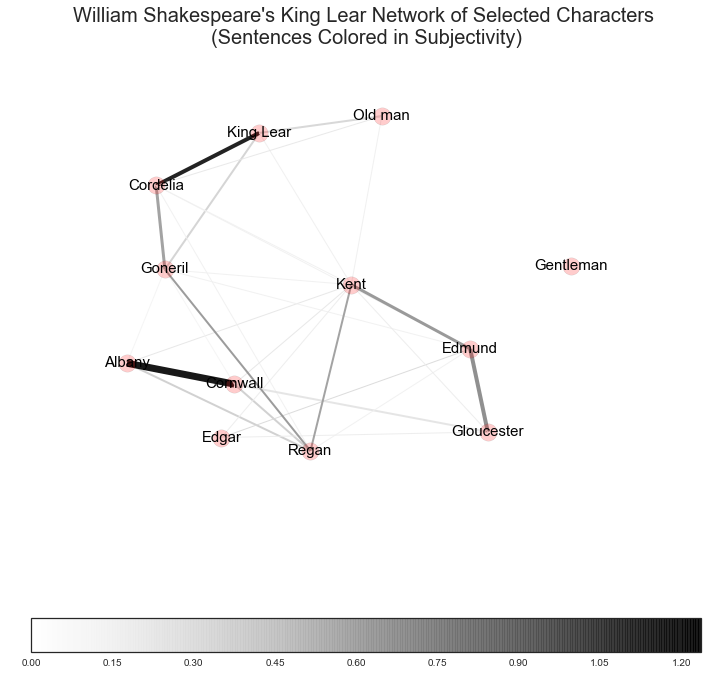

In [24]:
sstt="%s Network of Selected Characters \n(Sentences Colored in Subjectivity)" %titlename
possit=draw_network(G,sstt,pos=posg,with_edgewidth=True,withLabels=True,labfs=15,valpha=0.2,ealpha=0.9,labelfont=15,
                   with_edgecolor=True,edgecolor='subjectivity',colormat='Greys')

### Centralities of Nodes in the Network of Sententially Co-Occurring Characters

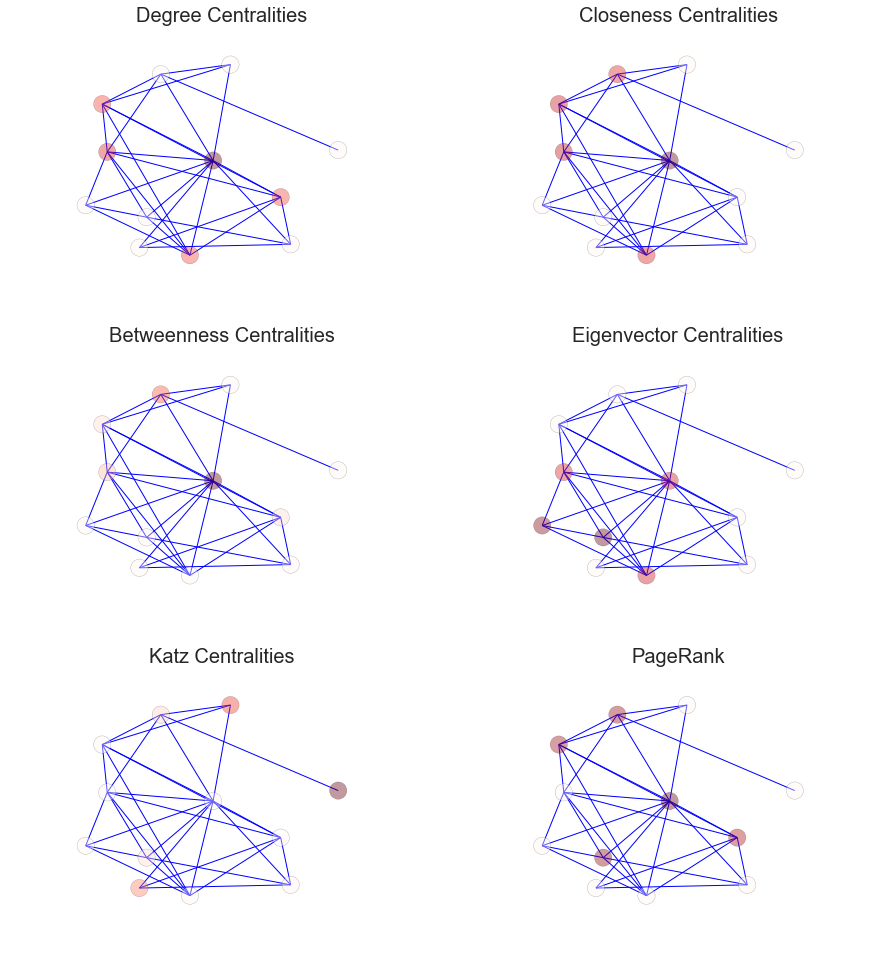

In [25]:
draw_centralities_subplots=tool.draw_centralities_subplots

centrali=draw_centralities_subplots(G,pos=posg,withLabels=False,labfs=5,figsi=(15,22),ealpha=1,vals=True)

### The table of Centralities of Nodes in the Network of Sententially Co-Occurring Characters 

In [26]:
dfc=pd.DataFrame()
u=0
for i,k in centrali.items():
    dfc.insert(u,i,k.values())
    u+=1
dfc.insert(0,'Nodes',centrali[centrali.keys()[0]].keys())
dfc

Nodes  closeness_centrality  katz_centrality  betweenness_centrality  \
0       Albany              0.578947         0.075627                0.000000   
1    King Lear              0.647059         0.100527                0.187879   
2      Old man              0.578947         0.364367                0.000000   
3    Gentleman              0.407407         0.578244                0.000000   
4     Cordelia              0.687500        -0.243453                0.048485   
5     Cornwall              0.611111         0.081230                0.021212   
6      Goneril              0.733333        -0.404743                0.083333   
7        Edgar              0.550000         0.250603                0.000000   
8         Kent              0.916667        -0.208827                0.337879   
9        Regan              0.647059        -0.340572                0.022727   
10  Gloucester              0.578947         0.024221                0.013636   
11      Edmund              0.647059        -0.253720                0.048485   

    page_rank  eigenvector_centrality  degree_centrality  
0    0.092903                0.452721           0.363636  
1    0.105864                0.426481           0.454545  
2    0.101557                0.217749           0.272727  
3    0.021499                0.280553           0.090909  
4    0.046302                0.342796           0.545455  
5    0.104469                0.325137           0.454545  
6    0.109311                0.020523           0.636364  
7    0.099569                0.343963           0.272727  
8    0.036173                0.099234           0.909091  
9    0.118262                0.274554           0.545455  
10   0.087925                0.080526           0.363636  
11   0.076166                0.231010           0.545455

### Communities of Nodes in the Network of Sententially Co-Occurring Characters 

Number of communities of William Shakespeare's King Lear Network of Selected Characters 
(Sentences Colored in Subjectivity) = 3
Community partition of William Shakespeare's King Lear Network of Selected Characters 
(Sentences Colored in Subjectivity):
[['Albany', 'Cornwall', 'Regan'], ['King Lear', 'Gentleman', 'Old man', 'Cordelia', 'Goneril'], ['Edgar', 'Kent', 'Gloucester', 'Edmund']]
Community modularity of William Shakespeare's King Lear Network of Selected Characters 
(Sentences Colored in Subjectivity) = 0.3266


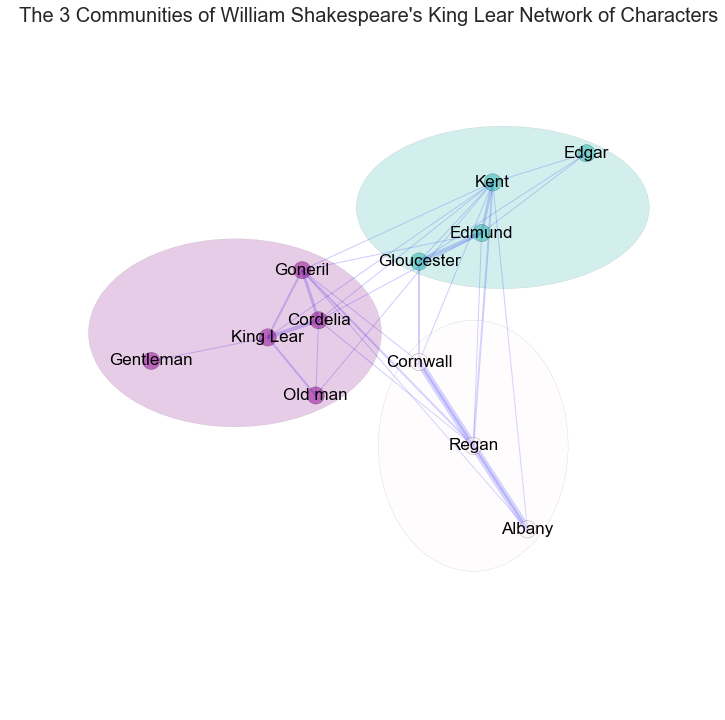

In [27]:
%autoreload 2

draw_comms=tool.draw_comms
modul_arity=tool.modul_arity
print_communities=tool.print_communities
part,nodper=print_communities(G,sstt)
ndfl=dflines[dflines['#_of_protagonists']>0  ]

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.2
vcc={}
sstta="The %s Communities of %s Network of Characters" %(max(part.values())+1,titlename)

draw_comms(G,G.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=17,valpha=0.5)

<a id='V'></a>
## V. Trajectories of Transitions among Sentential Co-Occurrences of Characters

### More about Transitions and Trajectories in Temporal Networks:

### http://www.slideshare.net/MosesBoudourides/trajectories1

In [28]:
%autoreload 2

trj= imp.load_source('trajectories', utilsdir+'trajectories_t.py')

### Transitions among Sentential Co-Occurrences of the Central Hero and Other Characters 

[['Goneril', 'Gentleman', 'Old man', 'Cordelia'], ['King Lear']]
['Goneril', 'Gentleman', 'Old man', 'Cordelia']

Statistics of trajectories of first mode vertices

Cordelia [['King Lear__2', 'King Lear__3'], ['King Lear__2', 'King Lear__6'], ['King Lear__5', 'King Lear__3'], ['King Lear__5', 'King Lear__6']]
1 trajectories analyzed.
['King Lear']

Statistics of trajectories of second mode vertices

King Lear [['Goneril__1', 'Gentleman__8']]
1 trajectories analyzed.


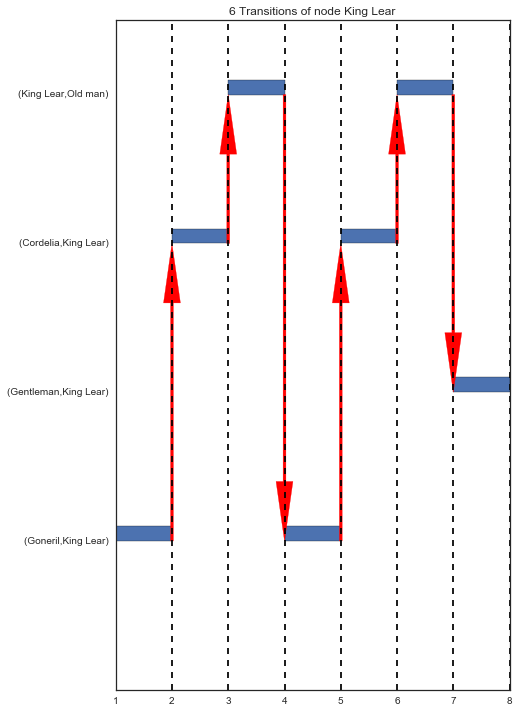

In [29]:
def search_in_list(x):
    l=x['protagonists']
    return central_hero in l
ndfl=dflines[dflines['#_of_protagonists']>1  ]
dialogs=ndfl[ndfl.apply(search_in_list,axis=1) ==True]
protagonists=dialogs.protagonists.tolist()
start=range(1,len(protagonists)+1)
end=range(2,len(protagonists)+2)
polarities=dialogs.polarity.tolist()
subj=dialogs.subjectivity.tolist()
qq=0
figi=None
search_name=central_hero

G,ndls,pold,subjd=trj.creatTestGraph_pandas_bips(start,end,protagonists,search_name,polarities,subj)
print ndls
trajpdfs=trj.main_work_search_name(G,ndls,qq,figi,search_name,verb=False,plot_first_mode=False)

### Statistics of the Trajectory of Transitions among Sentential Co-Occurrences of the Central Hero and Other Characters 

In [30]:
trajpdfs[nn3]  #["['Hamlet']"]

Vertices  fOriginator  fTransmitter  fTerminator  fBlackHole  \
0    Goneril          1.0           1.0          0.0         0.0   
1  Gentleman          0.0           0.0          1.0         0.0   
2    Old man          0.0           2.0          0.0         0.0   
3   Cordelia          0.0           2.0          0.0         0.0   

   fInvolvement  pOriginator  pTransmitter  pTerminator  pBlackHole  \
0           1.0          1.0           1.0          0.0         0.0   
1           1.0          0.0           0.0          1.0         0.0   
2           1.0          0.0           2.0          0.0         0.0   
3           1.0          0.0           2.0          0.0         0.0   

   lOriginator  lTransmitter  lTerminator  lBlackHole  lInvolvement  Position  \
0          7.0           7.0          0.0         0.0           7.0       2.5   
1          0.0           0.0          7.0         0.0           7.0       7.0   
2          0.0           7.0          0.0         0.0           7.0       4.5   
3          0.0           7.0          0.0         0.0           7.0       3.5   

   RelPosition  Betweenness  
0    25.000000          0.0  
1   100.000000          0.0  
2    58.333333         16.0  
3    41.666667         10.0

### The Trajectory of Transitions among Sentential Co-Occurrences of the Central Hero and Other Characters:

#### Nodes are Co-Occurrences of the Central Hero with Other Characters 

#### The Color of Nodes Corresponds to Sentential Sentiment Polarities Varying from Color Red (-1) to Color Green (1)

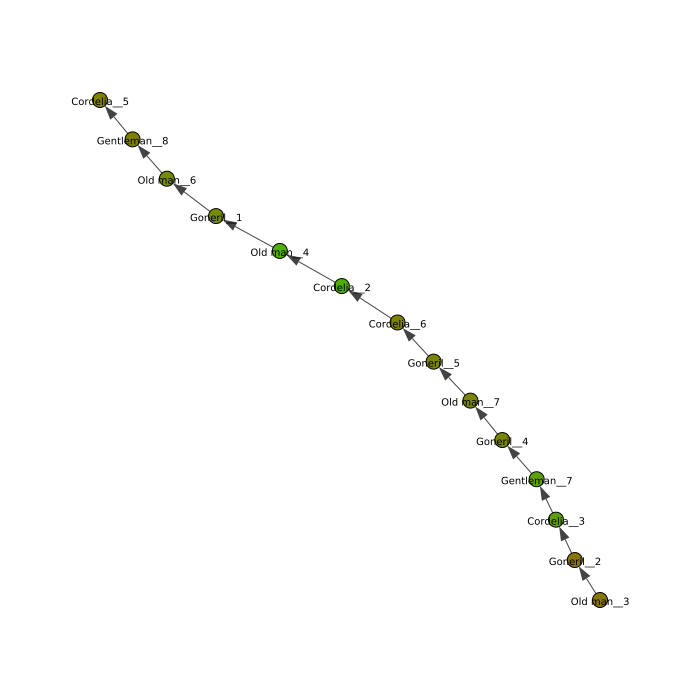

In [31]:
%autoreload 2
import igraph as ig

igraph_draw_traj=tool.igraph_draw_traj
filname=filename1 #'S_out_graphs/%s_graph.graphml' %search_name
g,visual_style,layout=igraph_draw_traj(filname,pold)

ig.plot(g,  **visual_style)

#### The Color of Nodes Corresponds to Sentential Sentiment Subjectivities Varying from Color Red (0) to Color Green (1)

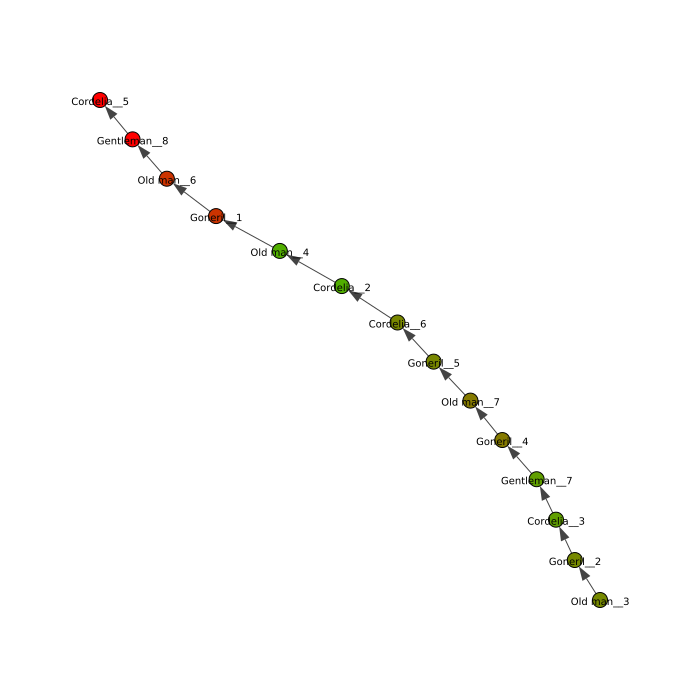

In [32]:
g,visual_style,layout=igraph_draw_traj(filname,subjd,polar=False,layout=layout)

ig.plot(g,  **visual_style)